In [ ]:
# Installation of FEniCS in Colab via
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

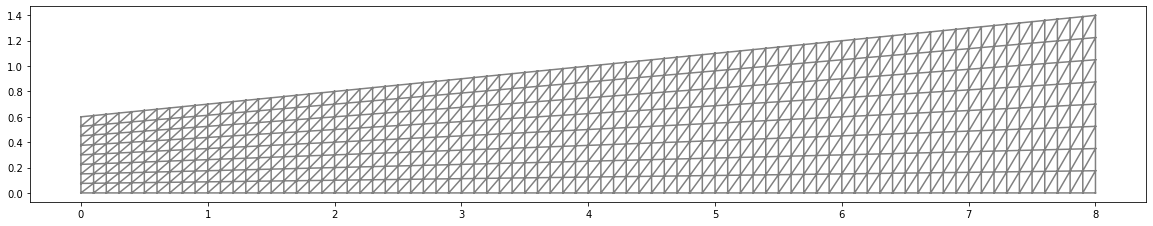

In [6]:
from fenics import *
from pylab import plt
import numpy as np

parameters["form_compiler"]["quadrature_degree"] = 3
parameters["form_compiler"]["cpp_optimize"] = True    

# Material constants
f     = Constant((0,1))
L     = Constant(8)
H     = Constant(1)
scale     = Constant(0.10)

rho0      = Constant(1.0)
theta     = Constant(0.5)
viscosity = Constant(0.02)
kappa     = Constant(1e+3)

t       = 0
T       = 50
n_steps = 500
dt      = T/(n_steps)

file1 = File("./output_sloshing_tank_fine/momentum.pvd")
mesh  = RectangleMesh(Point(0,0),Point(L,H),80,8,diagonal="right")

# Define boundary condition
def boundary_bot(x, on_boundary):
    return near(x[1],0)

def boundary_side(x, on_boundary):
    return near(x[0], 0) or near(x[0],L) 

# Define the functional space
P2 = VectorElement("P", mesh.ufl_cell(), 2)
W  = FunctionSpace(mesh, MixedElement([P2,P2,P2,P2]))

# Boundary conditions, forcing terms, and initial conditions
initial = Expression(("0","0","0","0","0", "0", "0", "0"), degree=2, t=0.0)
bc1  =  DirichletBC(W.sub(2).sub(1), Constant(0), boundary_bot)  
bc2  =  DirichletBC(W.sub(3).sub(1), Constant(0), boundary_bot)
bc3  =  DirichletBC(W.sub(2).sub(0), Constant(0), boundary_side)
bc4  =  DirichletBC(W.sub(3).sub(0), Constant(0), boundary_side)
bc = [bc1,bc2,bc3,bc4]

# Initial displacement of domain
initial_map = Expression(('0','scale*x[1]*(x[0]-L/2)'),scale=scale,L=L, pi = np.pi, degree=1)
ALE.move(mesh,initial_map)

plt.figure(figsize=(20,10))
plot(mesh)

### Time dependent Stokes equation ###

In [7]:
# Output routine
def output(q, t=0):
    # Output
    fw,fp,w,p = q.split()
    p.rename('p', 'Momentum')
    tmp  = Function(W)
    ALE.move(mesh, q.sub(2))
    file1 << (p, t)
    tmp.assign(-q)
    ALE.move(mesh, tmp.sub(2))

def evolve(old_q, dt):
    old_fw,old_fp,old_w, old_p = split(old_q)

    q = Function(W)           # Current solution
    fw,fp,w,p = split(q)
    
    # Test functions
    dq = TestFunction(W)      # Test functions
    dfw,dfp,dw,dp = TestFunctions(W)

    # Define elasticity stuff
    d = w.geometric_dimension()
    I = Identity(d)
    F = grad(w)+I
    J = det(F)

    # energy H = Total = Kinetic + Potential
    x0 = SpatialCoordinate(mesh)
    e_kinetic   = p**2/(2*rho0)
    e_potential = ( kappa*(J-1)**2 + inner(f,x0+w) )
    H           = ( e_kinetic + e_potential )*dx
    
    # Residual of E(psi) in the direction of dpsi:
    Res = derivative(H, q, dq)

    # Time derivatives
    dot_p = (p-old_p)/dt
    dot_w = (w-old_w)/dt
    
    # Solid forces fw=dH/dw, fp=dH/dp & Hamiltonian part dot(w,p)=J*(fw,fp)
    Res += inner(-fw, dw )*dx 
    Res += inner(-fp, dp )*dx 
    Res += inner( dot_w, dfw )*dx - inner( (1-theta)*fp+theta*old_fp, dfw )*dx
    Res += inner( dot_p, dfp )*dx + inner( (1-theta)*fw+theta*old_fw, dfp )*dx 
    Res += viscosity * inner(grad(fp)*inv(F),grad(dfp)*inv(F))*J*dx

    # Solve
    q.assign(old_q)
    solve(Res == 0, q, bc)

    # Compute energies
    E_kin = assemble(e_kinetic*dx)
    E_pot = assemble(e_potential*dx)
    E_tot = assemble(H)
    R_dis = assemble(viscosity*inner(grad(fp)*inv(F),grad(fp)*inv(F))*J*dx)

    
    return q,E_tot,E_kin,E_pot,R_dis

# Solution at time t = 0
t = 0
old_q = interpolate(initial, W)
energies = []
for i in range(n_steps+1):
    t += dt
    q,E_tot,E_kin,E_pot,R_dis = evolve(old_q, dt)    
    old_q.assign(q)
    energies.append([i,t,E_kin,E_pot,R_dis,E_tot])
    print("iter: %d t: %4.1f E_kin: %8.6f E_pot: %8.6f E_tot: %8.6f" % (i,t,E_kin,E_pot,E_tot))
    output(q,t)

E = list(zip(*energies))
t = E[1]

plt.plot(t, E[2], label="E_kin")
plt.plot(t, E[3], label="E_pot")
plt.plot(t, E[5], label="E_tot")
plt.legend(loc="upper left")
plt.xlabel("time")
plt.ylabel("energy")
plt.savefig(output_folder + "energy.png",quality=100,dpi=600)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
iter: 0 t:  0.1 E_kin: 0.000146 E_pot: -0.000906 E_tot: -0.000760
iter: 1 t:  0.2 E_kin: 0.000778 E_pot: -0.001540 E_tot: -0.000762
iter: 2 t:  0.3 E_kin: 0.002090 E_pot: -0.002857 E_tot: -0.000767
iter: 3 t:  0.4 E_kin: 0.004089 E_pot: -0.004870 E_tot: -0.000781
iter: 4 t:  0.5 E_kin: 0.006720 E_pot: -0.007517 E_tot: -0.000797
iter: 5 t:  0.6 E_kin: 0.009906 E_pot: -0.010728 E_tot: -0.000823
iter: 6 t:  0.7 E_kin: 0.013627 E_pot: -0.014488 E_tot: -0.000862
iter: 7 t:  0.8 E_kin: 0.017922 E_pot: -0.018817 E_tot: -0.000895
iter: 8 t:  0.9 E_kin: 0.022726 E_pot: -0.023681 E_tot: -0.000955
iter: 9 t:  1.0 E_kin: 0.027990 E_pot: -0.029000 E_tot: -0.001009
iter: 10 t:  1.1 E_kin: 0.033638 E_pot: -0.034710 E_tot: -0.001071
iter: 11 

iter: 119 t: 12.0 E_kin: 0.177572 E_pot: -0.198652 E_tot: -0.021080
iter: 120 t: 12.1 E_kin: 0.180910 E_pot: -0.202317 E_tot: -0.021407
iter: 121 t: 12.2 E_kin: 0.183656 E_pot: -0.205448 E_tot: -0.021792
iter: 122 t: 12.3 E_kin: 0.185844 E_pot: -0.207986 E_tot: -0.022141
iter: 123 t: 12.4 E_kin: 0.187261 E_pot: -0.209849 E_tot: -0.022588
iter: 124 t: 12.5 E_kin: 0.187950 E_pot: -0.210966 E_tot: -0.023015
iter: 125 t: 12.6 E_kin: 0.187763 E_pot: -0.211232 E_tot: -0.023469
iter: 126 t: 12.7 E_kin: 0.186539 E_pot: -0.210555 E_tot: -0.024016
iter: 127 t: 12.8 E_kin: 0.184422 E_pot: -0.208884 E_tot: -0.024462
iter: 128 t: 12.9 E_kin: 0.181094 E_pot: -0.206164 E_tot: -0.025070
iter: 129 t: 13.0 E_kin: 0.176839 E_pot: -0.202420 E_tot: -0.025581
iter: 130 t: 13.1 E_kin: 0.171545 E_pot: -0.197650 E_tot: -0.026105
iter: 131 t: 13.2 E_kin: 0.165182 E_pot: -0.191907 E_tot: -0.026725
iter: 132 t: 13.3 E_kin: 0.158181 E_pot: -0.185287 E_tot: -0.027106
iter: 133 t: 13.4 E_kin: 0.150162 E_pot: -0.1778

iter: 240 t: 24.1 E_kin: 0.046903 E_pot: -0.106578 E_tot: -0.059675
iter: 241 t: 24.2 E_kin: 0.050642 E_pot: -0.110900 E_tot: -0.060257
iter: 242 t: 24.3 E_kin: 0.054075 E_pot: -0.114798 E_tot: -0.060723
iter: 243 t: 24.4 E_kin: 0.056931 E_pot: -0.118151 E_tot: -0.061221
iter: 244 t: 24.5 E_kin: 0.059088 E_pot: -0.120898 E_tot: -0.061809
iter: 245 t: 24.6 E_kin: 0.060854 E_pot: -0.123045 E_tot: -0.062191
iter: 246 t: 24.7 E_kin: 0.061801 E_pot: -0.124567 E_tot: -0.062767
iter: 247 t: 24.8 E_kin: 0.062384 E_pot: -0.125534 E_tot: -0.063150
iter: 248 t: 24.9 E_kin: 0.062426 E_pot: -0.125987 E_tot: -0.063561
iter: 249 t: 25.0 E_kin: 0.062039 E_pot: -0.126031 E_tot: -0.063991
iter: 250 t: 25.1 E_kin: 0.061545 E_pot: -0.125799 E_tot: -0.064254
iter: 251 t: 25.2 E_kin: 0.060745 E_pot: -0.125390 E_tot: -0.064645
iter: 252 t: 25.3 E_kin: 0.060060 E_pot: -0.124928 E_tot: -0.064868
iter: 253 t: 25.4 E_kin: 0.059348 E_pot: -0.124491 E_tot: -0.065143
iter: 254 t: 25.5 E_kin: 0.058806 E_pot: -0.1241

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  74d7efe1e84d65e9433fd96c50f1d278fa3e3f3f
*** -------------------------------------------------------------------------


Text(0, 0.5, 'energy')

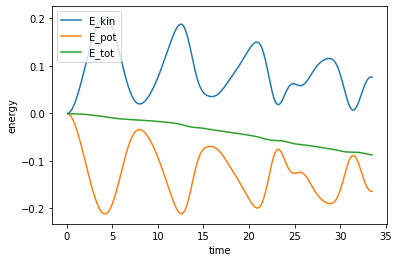

In [9]:
E = list(zip(*energies))
t = E[1]

plt.plot(t, E[2], label="E_kin")
plt.plot(t, E[3], label="E_pot")
plt.plot(t, E[5], label="E_tot")
plt.legend(loc="upper left")
plt.xlabel("time")
plt.ylabel("energy")
#plt.savefig(output_folder + "energy.png",quality=100,dpi=600)